# Genetic Neural Network Tutorial

This is a tutorial to implement a feedforward neural network using a genetic algorithm to train the network. The "go-to" approach for training a neural network is typically backpropagation but there is merit to experimenting with metaheuristics to optimize network weights.

I've previously written a tutorial on both <a href="../neural-network">neural networks (using backpropagation)</a> and <a href="../genetic-algorithms">genetic algorithms</a> and in my genetic algorithms tutorial I mentioned some applications of genetic algorithms which included training a neural network. I want to integrate my two tutorials into one and show how a neural network can be trained using a genetic algorithm taking the place of backpropagation.

This tutorial does presuppose you've read the linked tutorials as I won't be retreading what a neural network is or does, or how genetic algorithms work. I only explain my implementation of a genetic algorithm trained neural network and whatever may be involved with that. Feel free to distribute, edit, make changes, improve, etc. this tutorial. If you publish this tutorial elsewhere, please let me know and link back.

## Neural Networks

Without a complete retread of my neural network tutorial, you should know that for the purpose of this tutorial, our neural network is simply a series of weights between neurons. Unlike with backpropagation training, where the network stored neural error deltas and outputs alongside their weights, we only really care about the weights. However, the neural network doesn't optimize the synapse weights, rather we rely on the metaheuristic instead for this purpose.

## Genetic Algorithms

For our neural network, we use a genetic algorithm to train the network. How? Genetic algorithms need a search space and fitness function (along with genetic parameters like crossover, mutation rates, etc.). A genetic algorithm is an optimizer, and a neural network using backpropagation operates in a similar way: over time, training using backpropagation will optimize the weights such that we minimize some error or loss function, such as the mean squared error. As accuracy in classification is inversely proportional to the error, a lower error means higher accuracy. 

To this end, we'll be using a genetic algorithm to minimize the mean squared error function using the search space of the weights. In other words, we optimize the weights of the network to reduce the error. The search space bounds aren't known a priori but we'll make some informed assumptions about the problem later. We do, however, know the search space is the possibilities of weights for the network.

Like a typical genetic algorithm, we know our search space and fitness function and we can generate a population of candidate solutions and evolve them over time. A candidate solution, or chromosome, in the population will be represented as a set of weights. Once our genetic algorithm is done, we simply encode the chromosome into a set of weights which we then initialize the network as.

### Pseudocode

Pseudocode for the algorithm is as below:

```
procedure ga-nn() is:
  initialize network strcutrue
  initialize random population p of size n
  for each epoch do:
    sort p by fitness
    select elites e from p
    select tournament t from p
    sort t by fitness
    clear contents of p
    initialize mating pool m
    add e to m and p
    add t[0] to m
    for i in range 0..(n- 0.size)/2 do:
      select two random parents p1, ps2 from m
      initialize empty child c1, c2
      c1 := crossover(p1, p2)
      c2 := crossover(p1, p2)
      mutate(c1)
      mutate(c2)
      add c1, c2 to p
    endfor
  endfor
  network weights := best from p  
endprocedure
```

Note this is identical to the pseudocode for the genetic algorithm as found in that tutorial with the only addition being the best from population serves as weight initialization for the network.

## Before you Begin

Thus tutorial uses Python and two non-standard dependencies:

- Python 3.6
- GNU/Linux (or WSL, LXSS, etc)
- X11 or alternative
- `matplotlib`
- `pandas`
- some data

We'll be using `matplotlib` to graph the mean squared error and model accuracy over time but otherwise doesn't need this library. I use it for illustrative purposes but you can omit it if you don't wish to verify the system works. `pandas` is used for a very important step: normalizing the data. The algorithm will work without it but at a detriment.

As for the data, I will be using the Wheat Seeds data set (see `/data`) but the implementation will be data agnostic. Since the network's input and output layer structures are dependent on the data, it will be generalized to take any data set and adjust the model as necessary.

## Loading the Data

Before implementing the network and metaheuristic, we need to handle how data is loaded and stored.

The Wheat Seeds data set consists of 210 examples of 7-dimensional data (seven continuous features per row) along with a discrete classification (three classes). We'll split the data into training and testing sets with a 70%/30% ratio. This means the network is trained on 70% of the data and tested upon the remaining 30%.

For our genetic algorithm to work, we need to know the search space. While we know the search space is the set of possible weight permutations, we don't yet know the boundaries of the search space. In fact, there's no declarative way to determine the space boundaries but we can make an informed guess that the weights will be relatively small and of similar magnitudes. We'll normalize our input data around `0` to shrink the total search space and make an assumption the weights will be within `[-3.00, 3.00]`.

Here we'll load the data, normalize it, and then split it into our training and testing portions:

In [1]:
import pandas as pd
from math import floor, ceil

def load_data(filename):
    """Loads CSV for splitting into training and testing data.
    
    Parameters:
        filename : the filename of the file to load.
    
    Returns:
        Two lists, each corresponding to training and testing data.
    """
    # load into pandas dataframe
    df = pd.read_csv(filename, header=None, dtype=float)
    # normalize the data
    for features in range(len(df.columns)-1):
        df[features] = (df[features] - df[features].mean())/df[features].std()
    train = df.sample(frac=0.70).fillna(0.00) # get training portion
    test = df.drop(train.index).fillna(0.00) # remainder testing portion
    return train.values.tolist(), test.values.tolist()

Using the above function, we load the CSV into a master dataframe, normalize the features, then take a random 70% sample as training data and use the remaining as testing data. We'll output the number of examples for each to verify as well as find the number of columns in the data (attributes) and the number of unique classifications in the data (classes):

In [2]:
# get training/testing data
TRAIN, TEST = load_data('./data/wheat.csv')

print(f'Training examples: {len(TRAIN)}')
print(f'Testing examples: {len(TEST)}')

# count number of attributes
FEATURES = len(TRAIN[0][:-1])
# count number of unique classifications
CLASSES = len(list(set([c[-1] for c in (TRAIN+TEST)])))

print(f'\nFeatures: {FEATURES}, Classes: {CLASSES}')

Training examples: 147
Testing examples: 63

Features: 7, Classes: 3


This is congruent with what we know about the data set in terms of features and classes. We'll use these counts when initializing the network shortly as we want the input layer size to match the number of attributes and the output layer to match the number of unique classifications. The input and output layers are a consequence of the data and not user defined.

## Initializing the Network

Since we know the size of the input and output layers, we need only come up with a hidden layer size to begin network initialization. We'll use eight hidden neurons in our lone hidden layer giving us a `7-8-3` network structure.

Later on we'll need a way to encode a chromosome to use as weights for the network, so our network initializer will take this into consideration. We're still using bias for our network, so each of our chromosomes will need to be `h * (n+1) + o * (h+1)` long, where `n` is the size of our input layer, `h` our hidden layer, and `o` our output layer. For our `7-8-3` network, this means chromosomes will be of length `91`.

Here is our network initializer:

In [3]:
HIDDEN_SIZE = 8

def initialize_network(c, n=FEATURES, h=HIDDEN_SIZE, o=CLASSES):
    """Neural network initializer.
    
    Parameters:
        c : the chromosome to encode into the network.
        n : the number of input neurons.
        h : the number of hidden neurons.
        o : the number of output neurons.
    
    Returns:
        The n-h-o neural network.
    """
    chr = iter(c) # make iterator from c
    neural_network = [] # initially an empty list
    # there are (n * h) connections between input layer and hidden layer
    neural_network.append([[next(chr) for i in range(n+1)] for j in range(h)])
    # there are (h * o) connections between hidden layer and output layer
    neural_network.append([[next(chr) for i in range(h+1)] for j in range(o)])
    return neural_network

Like how a network should have its weights initialized within some small range such as `[-1.00, 1.00]` or `[0.00, 1.00]`, the initial chromosomes should be much the same. Right now we'll make a sample chromosome and output the network structure to verify it's working as intended:

In [4]:
import random

CHROMOSOME_SIZE = (HIDDEN_SIZE * (FEATURES+1)) + \
    (CLASSES * (HIDDEN_SIZE+1))

SAMPLE_CHROMOSOME = [round(random.uniform(-1.00, 1.00),4) \
    for _ in range(CHROMOSOME_SIZE)]

NETWORK = initialize_network(SAMPLE_CHROMOSOME)

for layer in NETWORK:
    for neuron in layer:
        print(neuron)
    print('\n')

[-0.1528, -0.1815,  0.1821, -0.8125, -0.3839,  0.7349,  0.9300, -0.1337]
[ 0.5811, -0.7446,  0.6616, -0.7300, -0.2670, -0.9829,  0.6506,  0.6974]
[-0.1812, -0.4661, -0.2924,  0.5708,  0.4378,  0.3506,  0.5579, -0.8190]
[-0.3167,  0.0967, -0.6212,  0.1855, -0.5138,  0.5325,  0.3319,  0.4833]
[ 0.4245,  0.6106, -0.3908, -0.0650,  0.3148,  0.0144, -0.4458,  0.4413]
[ 0.0962, -0.2165, -0.3902,  0.2854, -0.3361,  0.7763,  0.1200,  0.5133]
[ 0.0565, -0.9461, -0.1226,  0.2350,  0.1641, -0.6342, -0.3815,  0.4601]
[-0.1506,  0.6724,  0.2020,  0.2757,  0.0317, -0.3052,  0.2001,  0.2122]

[-0.0540,  0.8749, -0.2194, -0.5846,  0.4507,  0.8495, -0.8175, -0.6932,  0.8858]
[-0.4282, -0.4970, -0.5103,  0.5976,  0.2769,  0.8606,  0.4901, -0.9824,  0.2385]
[ 0.5372, -0.2250,  0.2035, -0.9608,  0.0369,  0.3600, -0.2761,  0.5125, -0.3623]


I've truncated it for readability. What you should take from this is there are two layers of connections (between the input and hidden layers, and between the hidden and output layers). For the first set of weights, there is a set for each of the neurons in the hidden layer (`8`), each consisting of `8` weights (`7` from input layer + `1` bias). For the second set of weights, there is a set for each of the neurons in the output layer (`3`), each of `9` weights (`8` from hidden layer + `1` bias). 

This is congruent with our expected structure, however seeing the structure is not terribly important right now.

## Fitness Function

So far, we have a way to encode the candidate solution into a network but not a way to test how well the network performs. We've established our fitness function will be the mean squared error function, and to this end, we need to implement some of the busywork involved with any feedforward neural network.

We'll need to feed data forward into the network (it is a feedforward network after all) to calculate the mean squared error, so much of the below is just an implementation of those requirements.

### Summing and Activation Functions

The summing function takes neural inputs and aggregates them to be sent to the next layer. In our network, for example, one of the hidden neurons takes eight inputs and needs to create one output from it. To this end, we use a summing function to concatenate them by using the weighted sum of the neural inputs. Each input will contribute a different amount to the output and we use the synapse weights to determine this.

In [5]:
def summing_function(weights, inputs):
    """Sums the synapse weights with inputs and bias.
    
    Parameters:
        weights : synaptic weights.
        inputs : a vector of inputs.
    
    Returns:
        The aggregate of inputs times weights, plus bias.
    """
    # bias is the final value in the weight vector
    bias = weights[-1]
    summ = 0.00 # to sum
    for i in range(len(weights)-1):
        # aggregate the weights with input values
        summ += (weights[i] * float(inputs[i]))
    return summ + bias

Once we have the weighted sum of the neural inputs, this sum is transferred to an activation function. This function determines the neuron activation or firing: for linear activations, this is a binary "ON" or "OFF", whereas with non-linear activations, it's a degree of "ON".

We'll use the rectified linear unit activation function:

$$\text{ReLU}(z) = \left\{ \begin{array}{ll} z & \text{if }z \geq 0 \\ 0 & \text{if }z \lt 0 \end{array} \right.$$

We can implement this like so:

In [6]:
from math import exp

def activation_function(z):
    """ReLU activation function.
    
    Parameters:
        z : summed output of neuron.
    
    Returns:
        The neuron activation based on the summed output.
    """
    return z if z >= 0 else 0

I've chosen ReLU because some of the problems inherent with ReLU, such as vanishing gradient or dead neurons are a non-issue when we're not using the activation derivative. ReLU is a great activation function when these issues are non-existent, which makes it the perfect candidate for our activation function.

We can plot this function to see what it looks like:

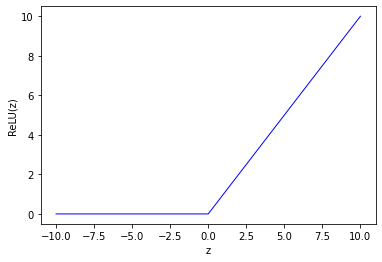

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt

x = range(-10, 10+1, 1)
y = [activation_function(z) for z in x]
plt.plot(x, y, c='blue', lw='1')
plt.ylabel('ReLU(z)')
plt.xlabel('z')
plt.show()
plt.clf()

Note it's a combination of linear ($f(x) = x$) and constant ($f(x) = 0$) functions. A negative signal is clamped to zero but otherwise unperturbed.

Now we've determined how a neuron will accept an input and produce an output. These two functions are all we need to implement our feedforward function.

### Feedforward Function

For our feedforward function, we only needed the summation and activation functions as previously defined. Data is fed into the network starting at the first layer, it is processed by the neurons in the input layer, neural outputs are calculated as a function of the data, the neuron's weighted sum of the data, and this value transferred to the activation function. Then, the next layer takes those outputs as inputs and the process cycles until you reach the output layer.

Since we don't need to store outputs within the neurons (as would be the case for backpropagation), the feedforward function need only return a value and not mutate the network in any way.

In [8]:
def feed_forward(network, example):
    """Feedforward method. Feeds data forward through network.
    
    Parameters:
        network : the neural network.
        example : an example of data to feed forward.
    
    Returns:
        The output of the forward pass.
    """
    layer_input, layer_output = example, []
    for layer in network:
        for neuron in layer:
            # sum the weight with inputs
            summ = summing_function(neuron, layer_input)
            # activate the sum, append output to outputs
            layer_output.append(activation_function(summ))
        # inputs become outputs of previous layer
        layer_input, layer_output = layer_output, []
    return layer_input # return the final output

We've done all of this because our error function demands the use of data being fed into the network to calculate the network error.

### Mean Squared Error

Now that we can feedforward data through the network, we can implement our error function, the mean squared error. The mean squared error function will feed all training data into the network and find the average error between them. The error is calculated as a function of what is known about the data (the classification is already known) versus what the network outputs.

In [9]:
def sse(actual, target):
    """Sum of Squared Error.
    
    Parameters:
        actual : network output.
        target : example target output.
    
    Returns:
        The sum of squared error of the network for an example.
    """
    summ = 0.00
    for i in range(len(actual)):
        summ += (actual[i] - target[i])**2
    return summ

def mse(network, training=TRAIN):
    """Mean Squared Error.
    
    Parameters:
        network : the neural network to test.
        training : a set of training data to test with.
    """
    summ = 0.00
    # for each training example
    for example in training:
        # populate a target vector
        target = [0 for _ in range(CLASSES)]
        # denote correct classification
        target[int(example[-1])] = 1
        # get actual output by feeding example through network
        actual = feed_forward(network, example)
        # sum up the sum of squared error
        summ += sse(actual, target)
    # MSE is just sum(sse)/number of examples
    return summ / len(training)

Note that the mean squared error is simply the mean of the sum of squared error per training example. This gives us the network error considering every training example.

## The Genetic Part

So far, we've only been fooling around with the neural network side of things when the brunt of this tutorial will instead focus on the genetic algorithm portion. Up to this point we've only found our fitness function.

As previously mentioned, we're using a genetic algorithm to train the network. This is a misnomer, as the use of a metaheuristic such as a genetic algorithm instead tries to find weights and doesn't update weights as an informed decision. It is, however, an informed search. We look at a population of weights, see which works the best, and make new populations which are variations of the prior population's best. To compare, a random search wouldn't be informed whereas a genetic algorithm makes decisions which ensure we get a better fitness over time.

### Representing Chromosomes

A chromosome for our algorithm is some encoding of network weights. Given a network, we need a way to represent it as a single array or list to make mutation and crossover easier later. To this end we'll consider a chromosome as a containerization of a network by storing its weights as an array or list as well as its fitness (as we don't want to do needless fitness calculations):

In [10]:
class Chromosome:
    """Chromosome class.
    Containerizes genes for chromosome.
    
    Attributes:
        genes : the weights of the network.
        fit : the fitness of the chromosome.
    """
    
    def __init__(self, genes, fit=None):
        """Chromosome constructor without fitness."""
        # initialize weights from parameter
        self.genes = genes
        # if no argument passed as fitness
        # take fitness from genes argument
        # else init as fit argument
        if fit is None:
            network = initialize_network(self.genes)
            self.fit = mse(network)
        else:
            self.fit = fit
    
    def set_genes(self, genes):
        """Genes mutator method."""
        self.genes = genes
        # when setting genes subsequent times
        # update the fitness
        network = initialize_network(self.genes)
        self.fit = mse(network)
    
    def get_genes(self):
        """Genes accessor method."""
        return self.genes
    
    def get_fit(self):
        """Fitness accessor method."""
        return self.fit

    def __lt__(self, other):
        """Less-than operator overload."""
        return self.fit < other.fit
    
    def __getitem__(self, key):
        """List index operator overload."""
        return self.genes[key]
    
    def __len__(self):
        """List length operator overload."""
        return len(self.genes)
    
    def __str__(self):
        """Printing operator overload."""
        return str(self.genes)

From this we have our chromosome genes representing network weights. We can directly check the fitness of a chromosome by decoding it into a network structure. We only check the fitness sometimes, however, as the fitness function is costly: if a chromosome is made as empty, fitness is calculated, otherwise it initializes fitness from parameter.

### Population Initialization

What we've done so far is we've defined our search space (weights), a fitness function (MSE), and showed how our chromosomes are represented. We don't know the bounds of the search space but it doesn't really matter. We first need a way to generate an initial population. We previously made a sample chromosome which was a chromosome of length `91` and had genes initialized as a random decimal value within the interval `[-0.50, 0.50]`. We'll use this knowledge for our population initialization. 

Our search space is in `91` dimensions, or the length of each chromosome, but we'll implement the population initializer as being dimensionality agnostic. We'll use a population of `50` for now.

In [11]:
POP_SIZE = 50 # the population size

def initialize_population(size, dim):
    """Initializes a random population.
    
    Parameters:
        size : the size of the population.
        dim : the dimensionality of the problem
    
    Returns:
        A random population of that many points.
    """
    population = [] # population stored as a list
    for _ in range(size): # for the size of the population
        genes = [random.uniform(-1.00, 1.00) for _ in range(dim)] # random genes
        chromosome = Chromosome(genes) # create the chromosome
        population.append(chromosome) # add to population
    return population

POPULATION = initialize_population(POP_SIZE, CHROMOSOME_SIZE)

We also need a way to sort the population. Before when we defined our chromosome class structure, we implemented a "less than" operator overload for this purpose. This makes sorting a one-line affair:

In [12]:
POPULATION.sort()

Then to see some of the most fit chromosomes, we'll make a short function to output the five best chromosomes along with their fitness. This function can be expensive because we reinitialize the network weights per chromosome but this is solely for this tutorial and the final code won't include this.

In [13]:
def print_five_best():
    for i in range(5):
        print(f'Chromosome {i+1} = {POPULATION[i].get_fit()}')

print_five_best()

Chromosome 1 = 0.7167595229431896
Chromosome 2 = 0.8228743884288151
Chromosome 3 = 0.8340461398929171
Chromosome 4 = 1.0308903661707902
Chromosome 5 = 1.077302716412207


Once we know the most fit chromosomes, the neural network portion takes a back seat and we apply our genetic operators and selection strategies to the population.

### Mating Pool Selection

The mating pool reflects the chromosomes which will create the new generation's population. We'll be using elites and tournaments. First, we'll get the elites:

In [14]:
from math import ceil

def elite_selection(population, percent):
    """Elite selection function.
    Stores elites to bring into the next generation and mating pool.
    
    Parameters:
        population : the population to take elites from.
        percent : the proportion of the population to consider elites.
    
    Returns:
        A list of elite solutions.
    """
    elites = []
    # grab percent% best individuals
    for i in range(ceil(len(population)*percent)):
        elites.append(population[i]) # and append to elites
    return elites

The proportion of elites should be empirically found but we'll use 5% for the sake of example. The proportion of elites should be small, within `[1, 5]` percent. Once an elite is added to the population, we no longer want them in the rest of the population or we may skew our tournament later.

In [15]:
MATING_POOL = []
ELITES = elite_selection(POPULATION, 0.05)
MATING_POOL.extend(ELITES)

del POPULATION[:len(ELITES)]

There's no point in printing the elites as these can be seen if you scroll up a little. 

We'll then select a tournament and tournament winner from remaining chromosomes in the population. A tournament is some proportion of the population like elites, but instead of taking the most fit individuals, we'll take random individuals, sort them by fitness, and return the winner of the tournament. This means less fit individuals can still impact the next generation, as we want some diversity in our chromosomes.

The proportion of tournament entrants should also be empirically found but it should be fairly small, such as within the interval `[1, 5]`. We'll use 2%.

In [16]:
def tournament_selection(population, percent):
    """Tournament selection function.
    Creates a tournament of random individuals and returns the best.
    
    Parameters:
        population : the population to take tournament from.
        percent : the proportion of the population who enters the tournament.
    
    Returns:
        Best fit individual from tournament.
    """
    tournament = []
    # grab percent% random individuals
    for i in range(ceil(len(population)*percent)):
        random_idx = random.randint(0, len(population)-1)
        tournament.append(population.pop(random_idx)) # append to tournament
    tournament.sort() # sort by fitness
    return tournament[0] # return best fit from tournament

Likewise we add these to the mating pool.

In [17]:
TOURNAMENT = tournament_selection(POPULATION, 0.02)
MATING_POOL.append(TOURNAMENT)

At this point we have our mating pool and can discredit the remainder of the population. We'll be making a new one soon using the chromosomes from the mating pool.

### Evolving the Population

Now we can evolve the population by performing our genetic operators. The two operators being used are crossover and mutation, the specific flavor of each being two-point and uniform respectively. These genetic operators will allow the new population to be generated from combinations from chromosomes in the mating pool while still introducing some random diversity through mutation.

First, we'll implement the two-point crossover operator. Two-point crossover combines parent chromosomes based on pivot points: when recombining parents to form children, genes are taken from one parent up to the first pivot point, from the second until the second pivot point, then from the first parent again until the end of the chromosome.

In [18]:
import copy

def crossover(parent_a, parent_b, cr):
    """Two-point crossover operator.
    
    Parameters:
        parent_a : the first parent.
        parent_b : the second parent.
        cr : the crossover chance.
    
    Returns:
        Two child chromosomes as a product of both parents.
    """
    # only perform crossover based on the crossover rate
    if random.uniform(0.00, 1.00) >= cr:
        child_a = Chromosome(parent_a.get_genes(), parent_a.get_fit())
        child_b = Chromosome(parent_b.get_genes(), parent_b.get_fit())
        return child_a, child_b
    genes_a, genes_b = [], []
    # find pivot points at random 1..n-1
    pivot_a = random.randint(1, len(parent_a)-1)
    # second pivot is between pivot_a..n-1
    pivot_b = random.randint(pivot_a, len(parent_a)-1)
    for i in range(0, len(parent_a)):
        # before first pivot, use genes from one parent
        if i < pivot_a:
            genes_a.append(parent_a[i])
            genes_b.append(parent_b[i])
        # before second pivot, use genes from second parent
        elif i < pivot_b:
            genes_a.append(parent_b[i])
            genes_b.append(parent_a[i])
        # after second pivot, use genes from first parent again
        else:
            genes_a.append(parent_a[i])
            genes_b.append(parent_b[i])
    return Chromosome(genes_a), Chromosome(genes_b)

While crossover allows children to be part of each parent, we don't want the population to be strictly based on the mating pool. Were the mating pool to contain only poorly fit individuals, this means the algorithm never improves towards more fit individuals. To this end we need a way to reintroduce diversity: using mutation.

We're using a Gaussian mutation operator. This is where the mutation will perturb a chromosome by altering a gene to be a random position within a normal distribution. Since our chromosomes were initialized randomly within the interval `[-1.00, 1.00]` and our chromosome doesn't widen the range of genes, we need to consider when the search space is outside of this interval. We need an exploratory factor which can allow some genes to be perturbed outside this interval, but rarely.

To grab from the normal distribution, we'll use the mean as the mean of all genes in the chromosome and a sigma of `0.9`. This means there's an approximately 57% chance a gene is perturbed outside `[-0.50, 0.50]`, a 26% chance outside `[-1.00, 1.00]`, and so on if the chromosome average were `0`. This allows the chromosome average to shift away from `0`, which then changes the distribution for later generations, etc.

Thus, if an optimal gene is outside our initialization range, it can still be found given a little effort.

In [19]:
def mutation(child, mr):
    """Mutation operator.
    
    Parameters:
        child : the chromosome to mutate.
        mr : the mutation chance.
    
    Returns:
        A mutated child.
    """
    # the new genes to make
    genes = [gene for gene in child.get_genes()]
    # gene average
    avg = sum(genes) / len(genes)
    for i in range(len(genes)):
        # only perform mutation based on the mutation rate
        if random.uniform(0.00, 1.00) <= MUTAT_RATE:
            # update that axes with random position
            genes[i] = random.gauss(mu=avg, sigma=0.9)
    # we don't need to update the fitness if the gene
    # hasn't changed, so only update genes if they've changed
    if genes != child.get_genes():
        child.set_genes(genes)
    return child

Note that we're mutating on a per gene basis, not per chromosome. This means each gene has a chance to mutated rather than just a chromosome has a chance to mutate.

Once we have our crossover and mutation operators defined, we can make a driver for the evolutionary part of the algorithm. We'll also define dummy crossover and mutation rate variables to test our evolution algorithm.

In [20]:
CROSS_RATE = 0.90
MUTAT_RATE = 0.20

def evolve(mating_pool, elites, pop_size, cr, mr):
    """Evolves population based on genetic operators.
    
    Parameters:
        mating_pool : where to select parents from.
        elites : previously found elites.
        pop_size : the population size.
        cr : crossover rate.
        mr : mutation rate.
    
    Returns:
        A new population of offspring from mating pool.
    """
    new_population = [] # store new population as list
    new_population += elites # add elites verbatim
    while len(new_population) < pop_size: # while population isn't at max size
        # get both parents indices
        p_a_idx = random.randrange(len(mating_pool))
        p_b_idx = random.randrange(len(mating_pool))
        # we don't mind parents having identical genes but we don't
        # want the parents to use the same index. Parent A can be
        # equal to Parent B, but Parent A cannot be Parent B
        if p_a_idx == p_b_idx:
            continue
        # get the parents from indices
        parent_a = mating_pool[p_a_idx]
        parent_b = mating_pool[p_b_idx]
        # find children using crossover
        child_a, child_b = crossover(parent_a, parent_b, cr)
        # mutate each child
        child_a = mutation(child_a, mr)
        child_b = mutation(child_b, mr)
        # add children to population
        new_population += [child_a, child_b]
    return new_population

We can try out our evolution algorithm by comparing the best five best candidates initially versus after one step of evolution:

In [21]:
print('Before evolution:')
print_five_best()

POPULATION = evolve(MATING_POOL, ELITES, POP_SIZE, \
    CROSS_RATE, MUTAT_RATE)
POPULATION.sort()

print('\nAfter evolution:')
print_five_best()

Before evolution:
Chromosome 1 = 1.0308903661707902
Chromosome 2 = 1.077302716412207
Chromosome 3 = 1.1025679850503154
Chromosome 4 = 1.1501852236126175
Chromosome 5 = 1.1998086917667854

After evolution:
Chromosome 1 = 0.7167595229431896
Chromosome 2 = 0.7345072994004964
Chromosome 3 = 0.8164335736703942
Chromosome 4 = 0.8228743884288151
Chromosome 5 = 0.8340461398929171


You can see just looking at a sample of the five best chromosomes in the population, they've all improved somewhat, converging closer to optimum.

Our evolution driver will use our selection strategies (elites and tournament) to devise a mating pool and then create the new population using our genetic operators.

## Other Performance Measures

Our goal with using the genetic algorithm to train our network is to optimize the weights such that the mean squared error function is minimized. We know classification accuracy is (roughly) inversely proportional to the mean squared error but we should examine this as well. We'll use this to make a nice graph later.

In [22]:
def performance_measure(chromosome, data):
    """Measures accuracy of the network using classification error.
    
    Parameters:
        chromosome : the chromosome to test.
        data : a set of data examples.
    Returns:
        A percentage of correct classifications.
    """
    network = initialize_network(chromosome)
    correct, total = 0, 0
    for example in data:
        # check to see if the network output matches target output
        if check_output(network, example) == float(example[-1]):
            correct += 1
        total += 1
    return 100*(correct / total)

def check_output(network, example):
    """Compares network output to actual output.
    
    Parameters:
        network : the neural network.
        example : an example of data.
    Returns:
        The class the example belongs to (based on network guess).
    """
    output = feed_forward(network, example)
    return output.index(max(output))

This is just another way for us to look at the network performance. We could even use the classification accuracy as our genetic algorithm fitness function but it is safer to use the mean squared error for this reason instead.

## Main Driver

That's everything we need to implement: we've successfully made a neural network which can train using a genetic algorithm. Below we'll make a main driver to drive population initialization, evolution, and network initialization from best.

In [23]:
ELITE_PROPORTION = 0.05 # proportion of elites
TOURN_PROPORTION = 0.03 # proportion of tournament
EPOCHS = 100 # how many generations
CROSS_RATE = 0.90 # crossover rate
MUTAT_RATE = 0.05 # mutation rate
POP_SIZE = 100 # how large a population is

MSE = [] # to store MSE over epochs
TRP = [] # training accuracy over epochs
TEP = [] # testing accuracy over epochs

def genetic_network(el_p, to_p, dim, epochs, pop_size, cr, mr):
    """Genetic Neural Network training function.
    
    Parameters:
        el_p : the proportion of elites
        to_p : the proportion of tournament
        dim : dimensionality of network.
        epochs : how many generations to run.
        pop_size : the population size.
        cr : crossover rate.
        mr : mutation rate.
    
    Returns:
        A trained neural network.
    """
    # initialize network as initially random
    population = initialize_population(pop_size, dim)
    for e in range(1, epochs+1):
        # sort the population by fitness
        population.sort()
        # get fitness of network
        MSE.append(population[0].get_fit())
        # training accuracy of network
        TRP.append(performance_measure(population[0].get_genes(), TRAIN))
        # testing accuracy of network
        TEP.append(performance_measure(population[0].get_genes(), TEST))
        mating_pool = [] # init mating pool
        # get elites from population
        elites = elite_selection(population, el_p)
        del population[:len(elites)] # remove elites
        # find tournament and winner
        t_winner = tournament_selection(population, to_p)
        # add tournament victor and elites to mating pool
        mating_pool.extend(elites)
        mating_pool.append(t_winner)
        # generate a new population based on mating pool
        population = evolve(mating_pool, elites, pop_size, cr, mr)
        mating_pool.clear() # clear mating pool for next gen
    population.sort()
    return initialize_network(population[0].get_genes())

# initialize network as trained from genetic algorithm
NETWORK = genetic_network(ELITE_PROPORTION, TOURN_PROPORTION, \
    CHROMOSOME_SIZE, EPOCHS, POP_SIZE, CROSS_RATE, MUTAT_RATE)

We have three global lists, `MSE`, `TRP`, and `TEP` to store the mean squared error, training performance, and testing performance per epoch of the algorithm. We can plot these:

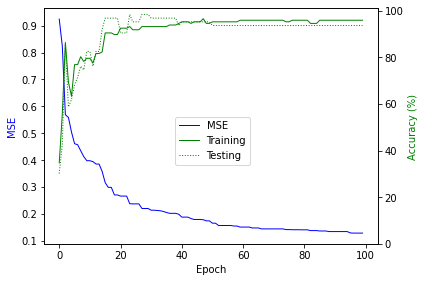

<Figure size 432x288 with 0 Axes>

In [24]:
def plot_data():
    x = range(0, EPOCHS)
    fig, ax2 = plt.subplots()
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MSE', color='blue')
    line, = ax2.plot(x, MSE, '-', c='blue', lw='1', label='MSE')
    ax1 = ax2.twinx()
    ax1.set_ylabel('Accuracy (%)', color='green')
    line2, = ax1.plot(x, TRP, '-', c='green', lw='1', label='Training')
    line3, = ax1.plot(x, TEP, ':', c='green', lw='1', label='Testing')
    fig.tight_layout()
    fig.legend(loc='center')
    ax1.set_ylim(0, 101)
    plt.show()
    plt.clf()
    
plot_data()

You can see over time the mean squared error is diminished, just as it would were you using backpropagation; as the mean squared error is inversely proportional to the accuracy of the network, you also see accuracy rise.

## Final Thoughts

It's interesting to think about a metaheuristic like genetic algorithms in training a network. A lot of literature and even what you may have learned in school were you to take a computer science degree use genetic algorithms in different ways. At least for me, using one to train a neural network isn't standard curriculum but it still has merit to its study.

Using this method to train a neural network, we can achieve mostly comparable results. What I didn't mention in this tutorial is how slow it can be compared to backpropagation. However, depending on parameter choices, it tends to converge faster but not necessarily to the same found optimum. It would be useful to define some termination condition (for example, terminate if MSE is below a certain threshold) as often you do not need to run for many epochs but this is problem specific.

Further consideration should be given to the activation function used. ReLU has many pitfalls in backpropagation trained networks but performs great in metaheuristic trained networks. I chose it specifically because this is one scenario where there are few drawbacks to doing so. You should still look into other types of activation functions and other types of genetic operators as I've kept it relatively simple here.

Lastly, we should address the search space. Here we've started from `[-0.50, 0.50]` and mutate based on a normal distribution around a chromosome average. If an optimal network weight is outside of this range, it can still be found, it just may take some time. Since the search space is not known a priori, different initialization and mutation intervals should be experimented with but empirically you'll find network weights are typically small within `[-10.00, 10.00]`. Normalizing the training and testing data around `0` can shrink the magnitude of the weights allowing a smaller search space to be used. This is where the guesswork is involved with genetic algorithms for network training.

## Finished Code

Here is the full uncommented code:

In [ ]:
#!/usr/bin/env python3

import pandas as pd
from math import floor, ceil, exp
import matplotlib.pyplot as plt
import random

class Chromosome:
    def __init__(self, genes, fit=None):
        self.genes = genes
        if fit is None:
            network = initialize_network(self.genes)
            self.fit = mse(network)
        else:
            self.fit = fit

    def set_genes(self, genes):
        self.genes = genes
        network = initialize_network(self.genes)
        self.fit = mse(network)

    def get_genes(self):
        return self.genes

    def get_fit(self):
        return self.fit

    def __lt__(self, other):
        return self.fit < other.fit

    def __getitem__(self, key):
        return self.genes[key]

def genetic_network(el_p, to_p, dim, epochs, pop_size, cr, mr):
    population = initialize_population(pop_size, dim)
    for e in range(1, epochs+1):
        population.sort()
        MSE.append(population[0].get_fit())
        TRP.append(performance_measure(population[0].get_genes(), TRAIN))
        TEP.append(performance_measure(population[0].get_genes(), TEST))
        mating_pool = []
        elites = elite_selection(population, el_p)
        del population[:len(elites)]
        t_winner = tournament_selection(population, to_p)
        mating_pool.extend(elites)
        mating_pool.append(t_winner)
        population = evolve(mating_pool, elites, pop_size, cr, mr)
        mating_pool.clear()
    population.sort()
    return initialize_network(population[0].get_genes())

def evolve(mating_pool, elites, pop_size, cr, mr):
    new_population = []
    new_population += elites
    while len(new_population) < pop_size:
        p_a_idx = random.randrange(len(mating_pool))
        p_b_idx = random.randrange(len(mating_pool))
        if p_a_idx == p_b_idx:
            continue
        parent_a = mating_pool[p_a_idx]
        parent_b = mating_pool[p_b_idx]
        child_a, child_b = crossover(parent_a, parent_b, cr)
        child_a = mutation(child_a, mr)
        child_b = mutation(child_b, mr)
        new_population += [child_a, child_b]
    return new_population

def crossover(parent_a, parent_b, cr):
    if random.uniform(0.00, 1.00) >= cr:
        child_a = Chromosome(parent_a.get_genes(), parent_a.get_fit())
        child_b = Chromosome(parent_b.get_genes(), parent_b.get_fit())
        return child_a, child_b
    genes_a, genes_b = [], []
    pivot_a = random.randint(1, len(parent_a.get_genes())-1)
    pivot_b = random.randint(pivot_a, len(parent_a.get_genes())-1)
    for i in range(0, len(parent_a.get_genes())):
        if i < pivot_a:
            genes_a.append(parent_a[i])
            genes_b.append(parent_b[i])
        elif i < pivot_b:
            genes_a.append(parent_b[i])
            genes_b.append(parent_a[i])
        else:
            genes_a.append(parent_a[i])
            genes_b.append(parent_b[i])
    return Chromosome(genes_a), Chromosome(genes_b)

def mutation(child, mr):
    genes = [gene for gene in child.get_genes()]
    avg = sum(genes) / len(genes)
    for i in range(len(genes)):
        if random.uniform(0.00, 1.00) <= mr:
            genes[i] = random.gauss(mu=avg, sigma=0.9)
    if genes != child.get_genes():
        child.set_genes(genes)
    return child

def initialize_population(size, dim):
    population = []
    for _ in range(size):
        genes = [random.uniform(-0.50, 0.50) for _ in range(dim)]
        chromosome = Chromosome(genes)
        population.append(chromosome)
    return population

def elite_selection(population, percent):
    elites = []
    for i in range(ceil(len(population)*percent)):
        elites.append(population[i])
    return elites

def tournament_selection(population, percent):
    tournament = []
    for i in range(ceil(len(population)*percent)):
        random_idx = random.randint(0, len(population)-1)
        tournament.append(population.pop(random_idx))
    tournament.sort()
    return tournament[0]

def initialize_network(c):
    n, h, o = FEATURES, HIDDEN_SIZE, CLASSES
    chr = iter(c)
    neural_network = []
    neural_network.append([[next(chr) for i in range(n+1)] for j in range(h)])
    neural_network.append([[next(chr) for i in range(h+1)] for j in range(o)])
    return neural_network

def feed_forward(network, example):
    layer_input, layer_output = example, []
    for layer in network:
        for neuron in layer:
            summ = summing_function(neuron, layer_input)
            layer_output.append(activation_function(summ))
        layer_input, layer_output = layer_output, []
    return layer_input

def summing_function(weights, inputs):
    """Sums the synapse weights with inputs and bias.

    Parameters:
        weights : synaptic weights.
        inputs : a vector of inputs.

    Returns:
        The aggregate of inputs times weights, plus bias.
    """
    bias = weights[-1]
    summ = 0.00
    for i in range(len(weights)-1):
        summ += (weights[i] * float(inputs[i]))
    return summ + bias

def activation_function(z):
    return z if z >= 0 else 0

def performance_measure(chromosome, data):
    network = initialize_network(chromosome)
    correct, total = 0, 0
    for example in data:
        if check_output(network, example) == float(example[-1]):
            correct += 1
        total += 1
    return 100*(correct / total)

def check_output(network, example):
    output = feed_forward(network, example)
    return output.index(max(output))

def sse(actual, target):
    summ = 0.00
    for i in range(len(actual)):
        summ += (actual[i] - target[i])**2
    return summ

def mse(network):
    training = TRAIN
    summ = 0.00
    for example in training:
        target = [0 for _ in range(CLASSES)]
        target[int(example[-1])] = 1
        actual = feed_forward(network, example)
        summ += sse(actual, target)
    return summ / len(training)

def load_data(filename):
    df = pd.read_csv(filename, header=None, dtype=float)
    for features in range(len(df.columns)-1):
        df[features] = (df[features] - df[features].mean())/df[features].std()
    train = df.sample(frac=0.70).fillna(0.00)
    test = df.drop(train.index).fillna(0.00)
    return train.values.tolist(), test.values.tolist()

def plot_data():
    x = range(0, EPOCHS)
    fig, ax2 = plt.subplots()
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MSE', color='blue')
    line, = ax2.plot(x, MSE, '-', c='blue', lw='1', label='MSE')
    ax1 = ax2.twinx()
    ax1.set_ylabel('Accuracy (%)', color='green')
    line2, = ax1.plot(x, TRP, '-', c='green', lw='1', label='Training')
    line3, = ax1.plot(x, TEP, ':', c='green', lw='1', label='Testing')
    fig.tight_layout()
    fig.legend(loc='center')
    ax1.set_ylim(0, 101)
    plt.show()
    plt.clf()

if __name__ == '__main__':
    MSE, TRP, TEP = [], [], []
    TRAIN, TEST = load_data('../data/wheat.csv')
    FEATURES = len(TRAIN[0][:-1])
    CLASSES = len(list(set([c[-1] for c in (TRAIN+TEST)])))
    HIDDEN_SIZE = 8
    CHROMOSOME_SIZE = (HIDDEN_SIZE * (FEATURES+1)) + \
        (CLASSES * (HIDDEN_SIZE+1))
    POP_SIZE = 100
    CROSS_RATE, MUTAT_RATE = 0.90, 0.05
    ELITE_PROPORTION, TOURN_PROPORTION = 0.05, 0.03
    EPOCHS = 200
    NETWORK = genetic_network(ELITE_PROPORTION, TOURN_PROPORTION, \
        CHROMOSOME_SIZE, EPOCHS, POP_SIZE, CROSS_RATE, MUTAT_RATE)
    plot_data()

You may wish to catch for errors (as I have done none here), and perhaps accept some of the parameters as command line arguments. This code, as-is, should run in a terminal but allows for zero customization unless you change the code manually. Some parameters might include hidden layer size, crossover and mutation rates, how many epochs, etc. This is just a basic implementation to springboard off of and experiment with.

You can save this code as `genetic_network.py` and execute it as one of the below:

```
$ python3 genetic_network.py
$ ./genetic_network.py
```

You can also find the code along with a commented version in `./code`.